In [1]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn_pandas import DataFrameMapper
import warnings
import skimage
from skimage import io, transform

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Find the minimal dimensions

In [2]:
from glob import glob

min_x = (float('Inf'), float('Inf'))
min_y = (float('Inf'), float('Inf'))

for image in glob('./data/shirts/*/*'):
    shape = io.imread(image).shape
    if shape[0] < min_x[0]:
        min_x = shape
    if shape[1] < min_y[1]:
        min_y = shape

print(min_x)
print(min_y)

(70, 85, 3)
(70, 52, 3)


## Let's go with 70x70 as a starting point, then?

Later updated to 100x100

In [3]:
NEW_SIZE = (100, 100, 3)
all_shirts = io.imread_collection('./data/shirts/*/*')

resized_images = []

for image in all_shirts:
#     io.imshow_collection([image, transform.resize(image, NEW_SIZE)])
    resized_images.append(transform.resize(image, NEW_SIZE))
    
resized_array = np.array(resized_images)
del(resized_images)

## Center the images

In [4]:
image_mean = np.mean(resized_array, axis=0)
centered_array = resized_array - image_mean
np.mean(centered_array)

-6.8579865961745587e-17

## Reshape for PCA

In [5]:
reshaped_array = centered_array.reshape(centered_array.shape[0], -1) # np.product(centered_array.shape[1:])
reshaped_array.shape

(237, 30000)

## PCA

In [6]:
pca = decomposition.PCA(whiten=True, copy=True)
pca.fit(reshaped_array)
diffs = np.ediff1d(pca.explained_variance_ratio_)

## Having some fun with the PCA components

In [7]:
first_50 = pca.components_[:50]
second_50 = pca.components_[50:100]

prod = np.matmul(first_50, second_50.T)


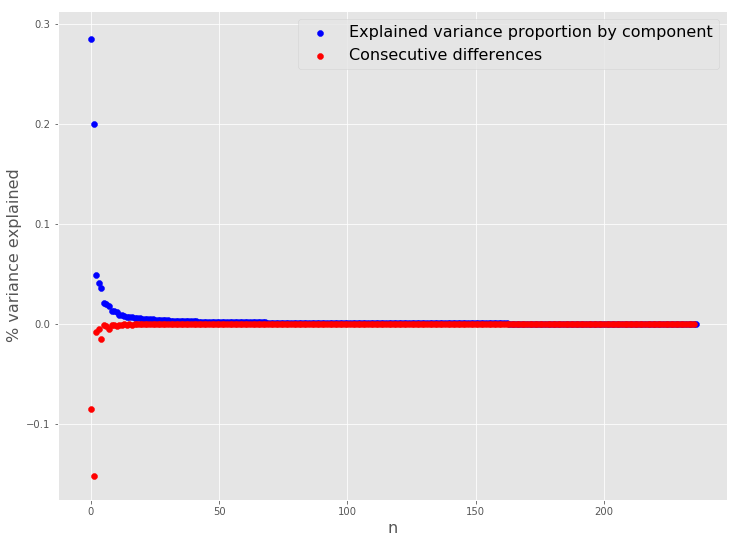

In [8]:
plt.figure(figsize=(12, 9))

plt.scatter(list(range(pca.explained_variance_ratio_.shape[0])), pca.explained_variance_ratio_, 
    color='blue', label='Explained variance proportion by component')

plt.scatter(list(range(diffs.shape[0])), diffs, 
    color='red', label='Consecutive differences')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'n', size=16)
plt.ylabel(r'% variance explained', size=16)
plt.show()

## Plot only for the first ~15

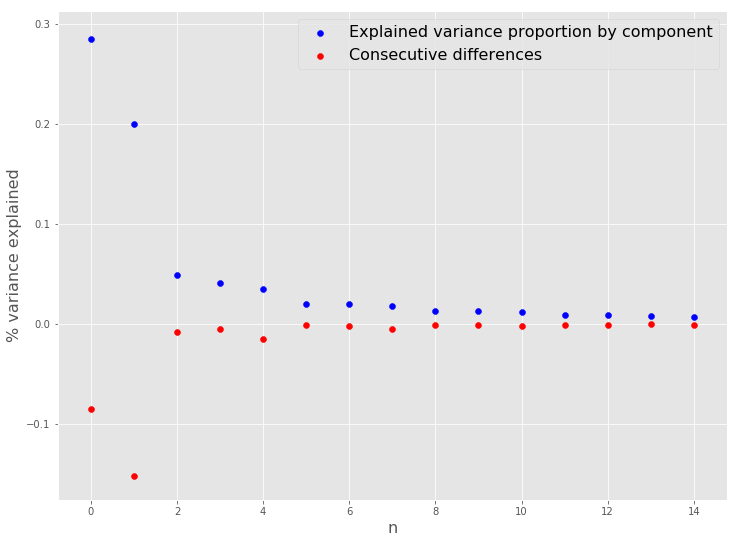

In [9]:
plt.figure(figsize=(12, 9))

NUM_ITEMS = 15

plt.scatter(list(range(NUM_ITEMS)), pca.explained_variance_ratio_[:NUM_ITEMS], 
    color='blue', label='Explained variance proportion by component')

plt.scatter(list(range(NUM_ITEMS)), diffs[:NUM_ITEMS], 
    color='red', label='Consecutive differences')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'n', size=16)
plt.ylabel(r'% variance explained', size=16)
plt.show()

## Looks like the first 5 principle components actually explain most of the variance

In [10]:
pca_top_5 = decomposition.PCA(n_components=5, whiten=True, copy=True)
transformed = pca_top_5.fit_transform(reshaped_array)

## Let's find the images most represented by each principle component

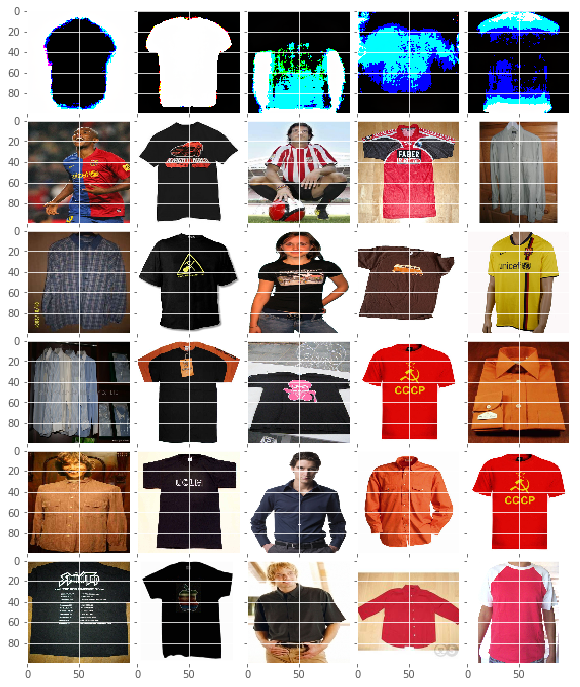

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid


components = pca_top_5.components_.copy()
components = [np.reshape(component, NEW_SIZE) for component in pca_top_5.components_]

fig = plt.figure(1, (10, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(5):
    grid[i].imshow(components[i])  # The AxesGrid object work as a list of axes.
    
for i, component in enumerate(pca_top_5.components_):
    top_five_indices = np.argpartition(reshaped_array.dot(component), -5)[-5:]
    top_five_images = np.take(resized_array, top_five_indices, axis=0)
    for j in range(5):
        grid[i + 5 * (j + 1)].imshow(top_five_images[j])
    

plt.show()


# Let's do some LDA instead

## Start by reloading the images by class

In [12]:
NEW_SIZE = (100, 100, 3)
formal_shirts = io.imread_collection('./shirts/formal_shirts/*')
shirts_and_jerseys = io.imread_collection('./shirts/shirts_and_jerseys/*')

resized_formal = []
for image in formal_shirts:
    resized_formal.append(transform.resize(image, NEW_SIZE))

n_formal = len(resized_formal)
    
resized_shirts = []
for image in shirts_and_jerseys:
    resized_shirts.append(transform.resize(image, NEW_SIZE))

n_jerseys = len(resized_shirts)

resized_combined = np.concatenate((np.array(resized_formal), np.array(resized_shirts)))
del(resized_formal)
del(resized_shirts)

## Center and reshape

In [13]:
image_mean = np.mean(resized_combined, axis=0)
centered_combined = resized_combined - image_mean
reshaped_combined = centered_combined.reshape(centered_combined.shape[0], np.product(centered_combined.shape[1:]))

## Split train-test to be able to assess classification accuracy (1)

In [14]:
from sklearn.model_selection import train_test_split

classes = [1] * n_formal + [0] * n_jerseys
X_train, X_test, y_train, y_test = train_test_split(reshaped_combined, classes, test_size=0.2, 
                                                    stratify=classes, random_state=RANDOM_SEED) 

## Classify using the raw data (2)

As computationally abhorrent as it might be - luckily the dataset is tiny

In [93]:
from sklearn.svm import SVC

parameters = {'C': [10 ** x for x in range(6)],
             'gamma': [10 ** (-1 * x) for x in range(6)]}

raw_svm = SVC(random_state=RANDOM_SEED)
raw_cv = GridSearchCV(raw_svm, parameters, n_jobs=4)
raw_cv.fit(X_train, y_train)

print('Train accuracy:', sum(raw_cv.predict(X_train) == y_train) / X_train.shape[0])
print('Test accuracy:', sum(raw_cv.predict(X_test) == y_test) / X_test.shape[0])

Train accuracy: 1.0
Test accuracy: 0.708333333333


## Classify using only PCA (3)

In [96]:
pca_top_5_train = decomposition.PCA(n_components=5, whiten=True, copy=True)
pca_transformed_train = pca_top_5_train.fit_transform(X_train)
print(pca_transformed_train.shape)
print('Top 5 component variances:', pca_top_5_train.explained_variance_ratio_[:5], 
      sum(pca_top_5_train.explained_variance_ratio_[:5]))
pca_transformed_test = pca_top_5_train.transform(X_test)


(189, 5)
Top 5 component variances: [ 0.2927303   0.19953641  0.05022244  0.03999685  0.03309346] 0.615579456606


In [70]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'C': [10 ** x for x in range(6)],
             'gamma': [10 ** (-1 * x) for x in range(6)]}

pca_svm = SVC(random_state=RANDOM_SEED, probability=True)
pca_cv = GridSearchCV(pca_svm, parameters, n_jobs=4)
pca_cv.fit(pca_transformed_train, y_train)

print('Train accuracy:', sum(pca_cv.predict(pca_transformed_train) == y_train) / pca_transformed_train.shape[0])
print('Test accuracy:', sum(pca_cv.predict(pca_transformed_test) == y_test) / X_test.shape[0])

Train accuracy: 0.830687830688
Test accuracy: 0.791666666667


## Classify using LDA (4)

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
print('Train accuracy:', sum(lda.predict(X_train) == y_train) / X_train.shape[0])
print('Test accuracy:', sum(lda.predict(X_test) == y_test) / X_test.shape[0])

Train accuracy: 0.888888888889
Test accuracy: 0.708333333333


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## See if we can use vectors from both to do better

In [30]:
def create_combined_X(X):
    return np.concatenate((pca_top_5_train.transform(X),
                           lda.transform(X)), axis=1)
                           
X_train_combined = create_combined_X(X_train)
X_train_combined.shape

(189, 6)

## Fit an SVM, cross-validating over some parameters

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'C': [10 ** x for x in range(6)],
             'gamma': [10 ** (-1 * x) for x in range(6)]}

svm = SVC(random_state=RANDOM_SEED, probability=True)
cv = GridSearchCV(svm, parameters, n_jobs=4)
cv.fit(X_train_combined, y_train)

print('Train accuracy:', sum(cv.predict(X_train_combined) == y_train) / X_train_combined.shape[0])
print('Test accuracy:', sum(cv.predict(create_combined_X(X_test)) == y_test) / X_test.shape[0])

Train accuracy: 0.888888888889
Test accuracy: 0.729166666667


## And for shits and giggles, a tree-based classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train_combined, y_train)

print('Train accuracy:', sum(tree.predict(X_train_combined) == y_train) / X_train_combined.shape[0])
print('Test accuracy:', sum(tree.predict(create_combined_X(X_test)) == y_test) / X_test.shape[0])

Train accuracy: 1.0
Test accuracy: 0.604166666667


## Last idea: can we ensemble the PCA and LDA classifiers to do better?

Hacking together my own emsembler, since the input data I want for each model is different

In [78]:
from functools import reduce

class HackyEnsembler:
    def __init__(self, models, weights=None, num_classes=2):
        if len(models) < 2:
            raise ValueError('Must receive at least two models to ensemble')
            
        self.models = models
        
        if weights and len(weights) != len(models):
            raise ValueError('Weights and models must be the same length')
        
        if weights is None:
            weights = [1.0] * len(models)
        
        # normalize
        self.weights = [w / sum(weights) for w in weights]
        
        self.num_classes = num_classes
        
    def _weighted_probs(self, *X_per_model):
        probs = [model.predict_proba(X) for model, X in zip(self.models, X_per_model)]
        weighted_probs = [p * w for p, w in zip (probs, self.weights)]
        return weighted_probs
    
    def predict_proba(self, *X_per_model):
        weighted_probs = self._weighted_probs(*X_per_model)
        sum_probs = reduce(np.add, weighted_probs)
        return sum_probs
        
    def predict(self, *X_per_model):
        probs = self.predict_proba(*X_per_model)
        return np.argmax(probs, axis=1)
    
    def max_prob_predict(self, *X_per_model):
        weighted_probs = self._weighted_probs(*X_per_model)
        concat_probs = np.concatenate(weighted_probs, axis=1)
        max_probs = np.argmax(concat_probs, axis=1)
        labels = np.mod(max_probs, self.num_classes)
        return labels
        

## Let's see if we can find a hacky way to cross-validate over weights

It's not really cross-validation since we're not refitting the model based on these weights, but it's something?

In [113]:
# Since the PCA model does better, we look at weights even and above
predict_max_train = 0
predict_weight = 0

max_prob_predict_max_train = 0
max_prob_predict_weight = 0

for pca_weight in np.linspace(1.0, 2.0, 20):
    weights = [pca_weight, 1]
    ens = HackyEnsembler((pca_cv, lda), weights)
    
    pred = sum(ens.predict(pca_transformed_train, X_train) == y_train) / \
        X_train_combined.shape[0]
    if pred > predict_max_train:
        predict_max_train = pred
        predict_weight = pca_weight
    
    max_prob_pred = sum(ens.max_prob_predict(pca_transformed_train, X_train) == y_train) / \
        X_train_combined.shape[0]
    if max_prob_pred > max_prob_predict_max_train:
        max_prob_predict_max_train = max_prob_pred
        max_prob_predict_weight = pca_weight
        
print(predict_max_train, predict_weight)
print(max_prob_predict_max_train, max_prob_predict_weight)

0.915343915344 1.21052631579
0.925925925926 1.15789473684


In [114]:
# ensemble_params = {'weights': [,
#              'gamma': [10 ** (-1 * x) for x in range(6)]}
        
ens = HackyEnsembler((pca_cv, lda), [predict_weight, 1])

print('Train accuracy:', sum(ens.predict(pca_transformed_train, X_train) == y_train) / \
      X_train_combined.shape[0])
print('Test accuracy:', sum(ens.predict(pca_transformed_test, X_test) == y_test) / \
      X_test.shape[0])
print()

ens = HackyEnsembler((pca_cv, lda), [max_prob_predict_weight, 1])

print('Max prob train accuracy:', sum(ens.max_prob_predict(pca_transformed_train, X_train) == y_train) / \
      X_train_combined.shape[0])
print('Max prob accuracy:', sum(ens.max_prob_predict(pca_transformed_test, X_test) == y_test) / \
      X_test.shape[0])

Train accuracy: 0.915343915344
Test accuracy: 0.75

Max prob train accuracy: 0.925925925926
Max prob accuracy: 0.791666666667


## One last curiosity: are all of the mistakes the same?

In [82]:
lda_predictions = lda.predict(X_test) == y_test
pca_predictions = pca_cv.predict(pca_transformed_test) == y_test

In [86]:
lda_predictions

array([ True,  True, False,  True, False, False, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

In [87]:
pca_predictions

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True, False,  True,
       False,  True,  True, False,  True, False,  True,  True,  True,
       False,  True,  True], dtype=bool)

In [89]:
np.logical_and(np.logical_not(lda_predictions),  np.logical_not(pca_predictions))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False], dtype=bool)

Looks like only 4 mistakes are shared between the models, out of 14 total mistakes for LDA and 10 for PCA. Thus this method has potential, at least theoretically, to lower the number of mistakes further.